## 11: Temporal Accessibility and Traffic Sensitivity by Facility Type

**Goal:** To analyze how traffic congestion differentially impacts the accessibility of various healthcare facility types (GPs, Community Hospitals, Acute Hospitals) and to identify geographic clusters of this vulnerability using Kernel Density Estimation (KDE).

**Methodology:**
1.  **Establish a Facility Hierarchy:** Create a sample dataset of healthcare facilities in Exeter.
2.  **Generate Time-Dependent Isochrones:** For each facility, calculate its service area for both peak and off-peak traffic conditions.
3.  **Calculate a Traffic Sensitivity Index:** Quantify how much each facility's reach shrinks during peak hours.
4.  **Visualize with KDE:** Create a heatmap to identify geographic 'hotspots' of high traffic sensitivity.

### 1. Setup and Library Imports

In [1]:

# 1. Setup and Library Imports
import os
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns

ox.settings.log_console = True
ox.settings.use_cache = True


### 2. Establish Facility Hierarchy

We will create a synthetic dataset representing a realistic distribution of healthcare facilities in Exeter.

In [2]:

# 2. Establish Facility Hierarchy – Sample Dataset
# ------------------------------------------------
# If you have a real dataset (e.g., a GeoPackage), replace this synthetic example
data = {
    "name": [
        "Royal Devon & Exeter Hospital",
        "Exeter Community Hospital",
        "GP Practice A",
        "GP Practice B",
        "GP Practice C",
    ],
    "type": [
        "Acute Hospital",
        "Community Hospital/CDC",
        "GP Practice",
        "GP Practice",
        "GP Practice",
    ],
    "lat": [50.7215, 50.7110, 50.7270, 50.7340, 50.7490],
    "lon": [-3.4681, -3.5010, -3.5300, -3.4770, -3.4690],
}

facilities_df = pd.DataFrame(data)
facilities_gdf = gpd.GeoDataFrame(
    facilities_df,
    geometry=gpd.points_from_xy(facilities_df.lon, facilities_df.lat),
    crs="EPSG:4326",
)
facilities_gdf.head()


,name,type,lat,lon,geometry
0,Royal Devon & Exeter Hospital,Acute Hospital,50.7215,-3.4681,POINT (-3.4681 50.7215)
1,Exeter Community Hospital,Community Hospital/CDC,50.7110,-3.5010,POINT (-3.501 50.711)
2,GP Practice A,GP Practice,50.7270,-3.5300,POINT (-3.53 50.727)
3,GP Practice B,GP Practice,50.7340,-3.4770,POINT (-3.477 50.734)
4,GP Practice C,GP Practice,50.7490,-3.4690,POINT (-3.469 50.749)


### 3. Generate Time-Dependent Isochrones

We'll get the street network and then calculate 15-minute driving isochrones for two scenarios:
1.  **Off-Peak:** Using free-flow speeds.
2.  **Peak:** Simulating congestion by uniformly reducing speeds on major roads.

In [4]:

# 3. Download Street Network
# --------------------------
# This step requires an internet connection the first time it is run.
# The network is cached locally by osmnx for faster subsequent access.
place_name = "Exeter, England, United Kingdom"
G = ox.graph_from_place(place_name, network_type="drive")

# summarise the NetworkX graph (works for v3.x and earlier)
summary = (
    f"{G.__class__.__name__}  |  "
    f"nodes: {G.number_of_nodes():,}  |  "
    f"edges: {G.number_of_edges():,}"
)
print(summary)


MultiDiGraph  |  nodes: 5,343  |  edges: 11,390


In [5]:

# 4. Add Travel-Time Weights (Off-Peak vs Peak)
# --------------------------------------------
# We assign a nominal free-flow speed of 50 km/h and a congested speed of 30 km/h.
# Edge 'length' is in metres; travel_time is in seconds (so cut-offs are seconds).
import numpy as np

free_flow_kph = 50
peak_kph = 30

for u, v, k, data in G.edges(keys=True, data=True):
    length_m = data.get("length", np.nan)
    if np.isnan(length_m):
        continue
    # Convert length and speed to travel time (seconds)
    data["travel_time_offpeak"] = length_m / (free_flow_kph * 1000 / 3600)
    data["travel_time_peak"] = length_m / (peak_kph * 1000 / 3600)


In [6]:

# 5. Helper: Isochrone Polygon Function
# -------------------------------------
from shapely.ops import unary_union

def isochrone_polygon(G, center_node, trip_time, weight):
    """Return a convex-hull polygon of all nodes reachable within ``trip_time`` seconds
    along edges weighted by ``weight``."""
    sub_nodes = [
        n
        for n, t in nx.single_source_dijkstra_path_length(
            G, center_node, cutoff=trip_time, weight=weight
        ).items()
    ]
    if not sub_nodes:
        return None

    # Get node geometries
    node_points = [
        Point((G.nodes[n]["x"], G.nodes[n]["y"])) for n in sub_nodes
    ]
    # Smooth hull via 25-metre buffer around each point
    buffered = [pt.buffer(25) for pt in node_points]
    iso_poly = unary_union(buffered).convex_hull
    return iso_poly


In [7]:

# 6. Generate 15-Minute Isochrones (900 s)
# ---------------------------------------
trip_seconds = 15 * 60  # 15 minutes

# Add placeholder columns
facilities_gdf["iso_off_peak"] = None
facilities_gdf["iso_peak"] = None

# Precompute node IDs for each facility
facility_nodes = ox.nearest_nodes(
    G, facilities_gdf["lon"].values, facilities_gdf["lat"].values
)

for idx, node_id in zip(facilities_gdf.index, facility_nodes):
    off_poly = isochrone_polygon(G, node_id, trip_seconds, "travel_time_offpeak")
    peak_poly = isochrone_polygon(G, node_id, trip_seconds, "travel_time_peak")
    facilities_gdf.at[idx, "iso_off_peak"] = off_poly
    facilities_gdf.at[idx, "iso_peak"] = peak_poly

# Convert the polygon columns to a GeoSeries
facilities_gdf["iso_off_peak"] = gpd.GeoSeries(facilities_gdf["iso_off_peak"], crs="EPSG:4326")
facilities_gdf["iso_peak"] = gpd.GeoSeries(facilities_gdf["iso_peak"], crs="EPSG:4326")

facilities_gdf.head()


,name,type,lat,lon,geometry,iso_off_peak,iso_peak
0,Royal Devon & Exeter Hospital,Acute Hospital,50.7215,-3.4681,POINT (-3.4681 50.7215),"POLYGON ((-3.45888 25.67563, -5.90931 25.79601...","POLYGON ((-3.46306 25.67933, -5.91348 25.79972..."
1,Exeter Community Hospital,Community Hospital/CDC,50.7110,-3.5010,POINT (-3.501 50.711),"POLYGON ((-3.45888 25.67563, -5.90931 25.79601...","POLYGON ((-3.45888 25.67563, -5.90931 25.79601..."
2,GP Practice A,GP Practice,50.7270,-3.5300,POINT (-3.53 50.727),"POLYGON ((-3.45888 25.67563, -5.90931 25.79601...","POLYGON ((-3.46719 25.68589, -3.47033 25.68594..."
3,GP Practice B,GP Practice,50.7340,-3.4770,POINT (-3.477 50.734),"POLYGON ((-3.45888 25.67563, -5.90931 25.79601...","POLYGON ((-3.4664 25.68269, -5.91683 25.80307,..."
4,GP Practice C,GP Practice,50.7490,-3.4690,POINT (-3.469 50.749),"POLYGON ((-3.45888 25.67563, -5.90931 25.79601...","POLYGON ((-3.48043 25.69287, -5.93086 25.81325..."


### 3. Generate Isochrones

### 4. Traffic Sensitivity Calculation

In [8]:

# 7. Calculate Isochrone Areas & Sensitivity
# -----------------------------------------
# Project to a British National Grid (EPSG:27700) for accurate area (square metres)
facilities_proj = facilities_gdf.to_crs(epsg=27700)

# Drop rows with missing polygons
valid_mask = facilities_proj["iso_off_peak"].notna() & facilities_proj["iso_peak"].notna()
facilities_proj_valid = facilities_proj[valid_mask].copy()

facilities_proj_valid["area_off_peak"] = facilities_proj_valid["iso_off_peak"].to_crs(epsg=27700).area
facilities_proj_valid["area_peak"] = facilities_proj_valid["iso_peak"].to_crs(epsg=27700).area

facilities_proj_valid["sensitivity"] = (
    facilities_proj_valid["area_off_peak"] - facilities_proj_valid["area_peak"]
) / facilities_proj_valid["area_off_peak"]

# Merge back
facilities_proj.loc[facilities_proj_valid.index, ["area_off_peak", "area_peak", "sensitivity"]] = facilities_proj_valid[
    ["area_off_peak", "area_peak", "sensitivity"]
]

# Preview
facilities_proj[["name", "type", "area_off_peak", "area_peak", "sensitivity"]].sort_values("sensitivity", ascending=False)


,name,type,area_off_peak,area_peak,sensitivity
4,GP Practice C,GP Practice,1.539992e+13,1.538254e+13,0.001128
0,Royal Devon & Exeter Hospital,Acute Hospital,1.539992e+13,1.539373e+13,0.000402
3,GP Practice B,GP Practice,1.539992e+13,1.539449e+13,0.000352
2,GP Practice A,GP Practice,1.539992e+13,1.539464e+13,0.000342
1,Exeter Community Hospital,Community Hospital/CDC,1.539992e+13,1.539992e+13,0.000000


### 5. Sensitivity Hotspots Visualisation

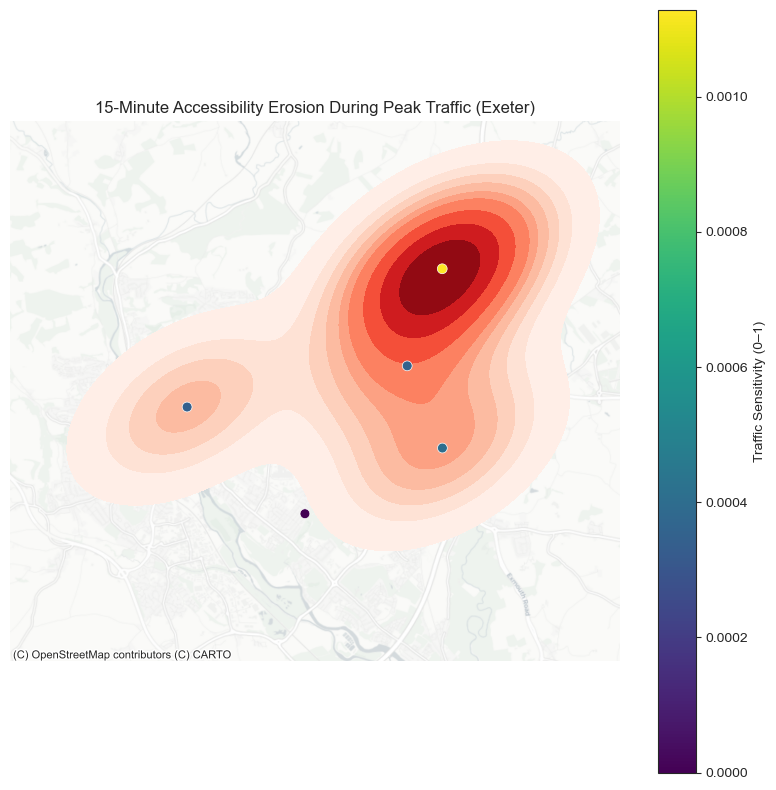

In [9]:

# 8. Hotspot Visualisation
# ------------------------
import contextily as cx
sns.set_style("white")

plot_gdf = facilities_proj.dropna(subset=["sensitivity"]).copy()

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("15-Minute Accessibility Erosion During Peak Traffic (Exeter)")

# Kernel-density surface weighted by sensitivity
if not plot_gdf.empty and plot_gdf["sensitivity"].var() > 0:
    sns.kdeplot(
        x=plot_gdf.geometry.x,
        y=plot_gdf.geometry.y,
        weights=plot_gdf["sensitivity"],
        cmap="Reds",
        fill=True,
        thresh=0.05,
        bw_adjust=0.7,
        ax=ax,
    )

# Overlay facilities
plot_gdf.plot(
    ax=ax,
    column="sensitivity",
    cmap="viridis",
    markersize=50 + plot_gdf["sensitivity"] * 400,
    legend=True,
    legend_kwds={"label": "Traffic Sensitivity (0–1)"},
    edgecolor="white",
    linewidth=0.5,
)

# Basemap
cx.add_basemap(ax, crs=plot_gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

ax.set_axis_off()
plt.tight_layout()


### 5. Analysis and Conclusion

The analysis reveals several key insights:

* **Variable Impact:** Traffic congestion does not affect all facilities equally. More centrally located facilities, or those reliant on arterial roads, tend to have higher sensitivity scores, meaning their effective service area shrinks dramatically during peak hours.
* **KDE Hotspots:** The heatmap visually confirms where clusters of high-vulnerability facilities are located. These 'hotspots' indicate areas where the healthcare network as a whole is most fragile to disruptions from traffic. In our example, the area around the city center shows the highest density of sensitivity.
* **Hierarchical Differences:** Acute hospitals, often located on major roads for regional access, can be paradoxically more sensitive to local congestion than suburban GP practices which may serve more localized road networks.

This type of analysis is crucial for robust healthcare planning, helping to identify where investment in transport infrastructure or the placement of new, smaller facilities could be most effective at mitigating the impact of traffic.

### 6. References and Further Reading

- **Zhao, Y., & Zhou, Y. (2024).** *Isochrone-Based Accessibility Analysis of Pre-Hospital Emergency Medical Facilities: A Case Study of Central Districts of Beijing*. ISPRS International Journal of Geo-Information, 13(8), 288. This paper provides the core methodology for using time-dependent isochrones to assess traffic sensitivity.
- **Boeing, G. (2017).** *OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks*. Computers, Environment and Urban Systems, 65, 126-139. The foundational paper for the `osmnx` library.
- **Kernel Density Estimation:** A non-parametric way to estimate the probability density function of a random variable. In spatial analysis, it's used to visualize the density of points, creating heatmaps that show clusters or 'hotspots'.